In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.1 MB/s eta 0:00:00


In [3]:
!pip install georasters

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [4]:

import rasterio
import numpy as np
import os
import pickle
import georasters as gr
#import cupy as cp

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
import requests
import urllib3
import xml.etree.ElementTree as ET

# Disable the SSL certificate verification warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Define the years of interest
years = range(2015, 2024)

# Define the FIPS codes for North Dakota counties along with their names
county_fips_codes = {
    "38001": "Adams", "38003": "Barnes", "38005": "Benson", "38007": "Billings", "38009": "Bottineau",
    "38011": "Bowman", "38013": "Burke", "38015": "Burleigh", "38017": "Cass", "38019": "Cavalier",
    "38021": "Dickey", "38023": "Divide", "38025": "Dunn", "38027": "Eddy", "38029": "Emmons",
    "38031": "Foster", "38033": "Golden_Valley", "38035": "Grand_Forks", "38037": "Grant", "38039": "Griggs",
    "38041": "Hettinger", "38043": "Kidder", "38045": "LaMoure", "38047": "Logan", "38049": "McHenry",
    "38051": "McIntosh", "38053": "McKenzie", "38055": "McLean", "38057": "Mercer", "38059": "Morton",
    "38061": "Mountrail", "38063": "Nelson", "38065": "Oliver", "38067": "Pembina", "38069": "Pierce",
    "38071": "Ramsey", "38073": "Ransom", "38075": "Renville", "38077": "Richland", "38079": "Rolette",
    "38081": "Sargent", "38083": "Sheridan", "38085": "Sioux", "38087": "Slope", "38089": "Stark",
    "38091": "Steele", "38093": "Stutsman", "38095": "Towner", "38097": "Traill", "38099": "Walsh",
    "38101": "Ward", "38103": "Wells", "38105": "Williams"
}

# Define the URL template
url_template = "https://nassgeo.csiss.gmu.edu/smap_service?service=WPS&version=1.0.0&request=Execute&identifier=GetFileByFips&DataInputs=layer=SMAP-9KM-DAILY-TOP_{year:04d}.{month:02d}.{day:02d}_AVERAGE;fips={fips}"

# Define the output directory
output_dir = "/content/drive/MyDrive/Conservatives-Official/Soil_Moisture"

# Define the specific dates you want to download
specific_dates = [5, 12, 19, 26]

# Iterate over each year
for year in years:
    # Iterate over each county FIPS code and name
    for fips, county_name in county_fips_codes.items():
        # Iterate over each month
        for month in range(4, 10):
            # Check if the month is February to determine the number of days
            num_days = 29 if month == 2 and (year % 4 == 0 and year % 100 != 0 or year % 400 == 0) else 28

            # Iterate over specific dates
            for day in specific_dates:
                # Ensure the day is within the range of the month
                if day <= num_days:
                    # Construct the URL
                    url = url_template.format(year=year, month=month, day=day, fips=fips)

                    # Send request to the URL with SSL certificate verification disabled
                    response = requests.get(url, verify=False)

                    # Check if the request was successful (status code 200)
                    if response.ok:
                        # Parse the XML response
                        root = ET.fromstring(response.content)
                        file_url_element = root.find(".//{http://www.opengis.net/wps/1.0.0}LiteralData")
                        if file_url_element is not None:
                            # Extract the file URL
                            file_url = file_url_element.text

                            # Extract the filename from the file URL
                            filename = os.path.basename(file_url)

                            # Define the output file path
                            output_file_path = os.path.join(output_dir, filename)

                            # Check if the file already exists
                            if not os.path.exists(output_file_path):
                                # Download the file
                                with open(output_file_path, "wb") as f:
                                    f.write(requests.get(file_url, verify=False).content)

                                # Print status message
                                print(f"Downloaded: {filename}")
                            else:
                                # Print status message if the file already exists
                                print(f"File already exists: {filename}")
                        else:
                            # Print error message if file URL is not found in the response
                            print(f"Error: File URL not found in response for {county_name}, FIPS {fips}, date {year}-{month:02d}-{day:02d}")
                    else:
                        # Print error message if request failed
                        print(f"Error downloading file for {county_name}, FIPS {fips}, date {year}-{month:02d}-{day:02d}: {response.status_code}")


Streaming output truncated to the last 5000 lines.
Downloaded: SMAP-9KM-DAILY-TOP_2020.08.05_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.08.12_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.08.19_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.08.26_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.09.05_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.09.12_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.09.19_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.09.26_AVERAGE_FIPS_38007.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.04.05_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.04.12_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.04.19_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.04.26_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.05.05_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.05.12_AVERAGE_FIPS_38009.tif
Downloaded: SMAP-9KM-DAILY-TOP_2020.05.

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.5 MB/s eta 0:00:00


In [3]:
!pip install georasters

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:

import rasterio
import numpy as np
import os
import pickle
import georasters as gr
#import cupy as cp

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
file_paths = os.listdir('/content/drive/MyDrive/Conservatives-Official/Soil_Moisture')
len(file_paths)

11448

In [7]:
img_paths = os.listdir('/content/drive/MyDrive/Conservatives-Official/Soil_Moisture')
print("No of Tif files:", len(img_paths))

No of Tif files: 11448


In [7]:
parent_dir = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture'

In [8]:
file_paths[0].split("_")

['SMAP-9KM-DAILY-TOP', '2023.06.05', 'AVERAGE', 'FIPS', '38023.tif']

In [27]:
import os
import shutil

def move_files_with_date(source_folder, destination_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get list of files in source folder
    files = os.listdir(source_folder)

    # Iterate through files
    for file in files:
        # Extract date from file name
        file_date = file.split('_')[1]
        # Check if date corresponds to the 12th day of the month
        if file_date.endswith("12"):
            # Construct full path of source file
            source_file = os.path.join(source_folder, file)
            # Construct full path of destination file
            destination_file = os.path.join(destination_folder, file)
            # Move file to destination folder
            shutil.move(source_file, destination_file)
            print(f"Moved {file} to {destination_folder}")

# Define source and destination folders
source_folder = "/content/drive/MyDrive/Conservatives-Official/Soil_Moisture"
destination_folder = "/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new"

# Move files with date on 12th day of the month from source folder to destination folder
move_files_with_date(source_folder, destination_folder)


Moved SMAP-9KM-DAILY-TOP_2023.06.12_AVERAGE_FIPS_38023.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.07.12_AVERAGE_FIPS_38023.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.08.12_AVERAGE_FIPS_38023.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.09.12_AVERAGE_FIPS_38023.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.04.12_AVERAGE_FIPS_38025.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.05.12_AVERAGE_FIPS_38025.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.06.12_AVERAGE_FIPS_38025.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.07.12_AVERAGE_FIPS_38025.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.08.12_AVERAGE_FIPS_38025.tif to /content/drive/MyDrive/Soil_Moisture_new
Moved SMAP-9KM-DAILY-TOP_2023.09.12_AVERAGE_FIPS_38025.tif to /content/dr

In [49]:
file_paths = os.listdir('/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new')
len(file_paths)

2438

In [50]:
parent_dir = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/'

In [51]:
import os
import pandas as pd

# Define the parent directory containing the TIFF files
parent_dir = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new'

# Get a list of file paths in the directory
file_paths = [os.path.join(parent_dir, file) for file in os.listdir(parent_dir) if file.endswith('.tif')]

# Initialize lists to store parsed information

county_ids = []
date= []

# Iterate over each file path
for file_path in file_paths:
    # Split the file name and extract information
    file_name = os.path.basename(file_path)
    file_details = file_name.split("_")

    # Extract information from the file name
    county_ids.append(file_details[4].split('.')[0])  # Remove '.tif' extension
    date.append(file_details[1])


In [52]:

# Create a DataFrame
data = {
    'County_ID': county_ids,
    'Date': date
}



In [53]:
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

     County_ID        Date
0        38023  2023.06.12
1        38023  2023.07.12
2        38023  2023.08.12
3        38023  2023.09.12
4        38025  2023.04.12
...        ...         ...
2433     38035  2015.08.12
2434     38035  2015.09.12
2435     38037  2015.05.12
2436     38037  2015.06.12
2437     38037  2015.07.12

[2438 rows x 2 columns]


In [33]:
df.shape

(2438, 2)

In [54]:

def tif_plot(img_path):
    # Read tiff file
    tiff_img = gr.from_file(img_path)
    tiff_img.plot()
    # Convert the tiff image to a NumPy array
    tiff_array = tiff_img.raster

    # Print the array shape
    print("Tiff Array Shape:", tiff_array.shape)

    return tiff_array

Tiff Array Shape: (4, 8)


masked_array(
  data=[[0.2221137285232544, 0.22148048877716064, 0.19895853102207184,
         0.2024146318435669, --, --, --, --],
        [0.2221137285232544, 0.22148048877716064, 0.1996222883462906,
         0.24845802783966064, 0.1859198957681656, 0.14784158766269684,
         0.1902381330728531, 0.2356024980545044],
        [0.1941749006509781, 0.1788855940103531, 0.1950141340494156,
         0.15881265699863434, 0.1825324445962906, 0.1850501447916031,
         0.2039099931716919, 0.2111731767654419],
        [0.08634483069181442, 0.1292334944009781, 0.15159524977207184,
         0.2411872148513794, 0.15475381910800934, 0.1619178205728531,
         0.2033606767654419, 0.22952187061309814]],
  mask=[[False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],
  fill_value=-9999.0,
  dtype=f

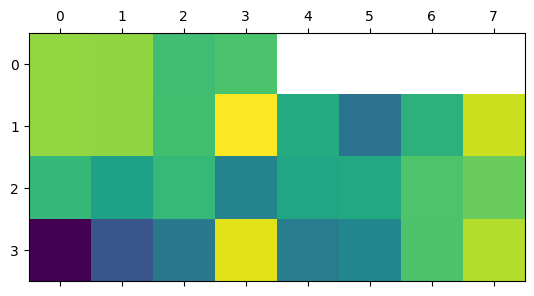

In [14]:
tif_plot('/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/SMAP-9KM-DAILY-TOP_2015.04.05_AVERAGE_FIPS_38001.tif')

In [15]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 19.1 MB/s eta 0:00:00


In [35]:
import tensorflow as tf

def tif_preprocessing(img_path):
    # Read GeoTIFF file
    raster_data = tf.io.read_file(img_path)
    # Decode GeoTIFF file
    raster_data = tf.image.decode_tiff(raster_data)
    # Transfer the raster data to TPU
    raster_data_tpu = tf.convert_to_tensor(raster_data)
    return raster_data_tpu


In [55]:

def tif_preprocessing(img_path):
    # Open GeoTIFF file
    with rasterio.open(img_path) as src:
        # Print raster properties
        #print("Raster bounds:", src.bounds)
        #print("Raster shape:", src.shape)

        # Read raster data
        raster_data = src.read(1)  # Read the first band
        # raster_data = np.array(raster_data)  # Convert to NumPy array
        #cupy_raster_data = cp.asarray(raster_data)
        # Print raster data
        #print("Raster data:", raster_data)
        #print(type(raster_data))
        return raster_data

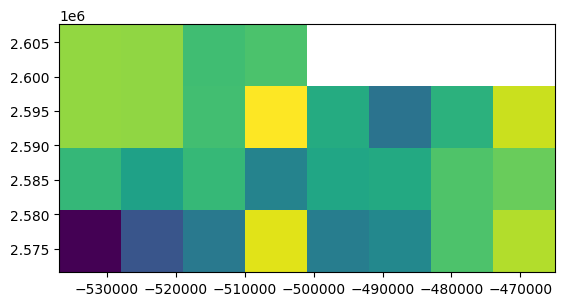

In [20]:
import rasterio
from rasterio.plot import show

def tif_plot(img_path):
    try:
        # Open GeoTIFF file
        with rasterio.open(img_path) as src:
            # Plot the GeoTIFF
            show(src)
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
tif_plot('/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/SMAP-9KM-DAILY-TOP_2015.04.05_AVERAGE_FIPS_38001.tif')


In [119]:
import numpy as np
import pandas as pd

# Define county_mapping dictionary
county_mapping = {
    38001: "Adams",
    38003: "Barnes",
    38005: "Benson",
    38007: "Billings",
    38009: "Bottineau",
    38011: "Bowman",
    38013: "Burke",
    38015: "Burleigh",
    38017: "Cass",
    38019: "Cavalier",
    38021: "Dickey",
    38023: "Divide",
    38025: "Dunn",
    38027: "Eddy",
    38029: "Emmons",
    38031: "Foster",
    38033: "Golden Valley",
    38035: "Grand Forks",
    38037: "Grant",
    38039: "Griggs",
    38041: "Hettinger",
    38043: "Kidder",
    38045: "LaMoure",
    38047: "Logan",
    38049: "McHenry",
    38051: "McIntosh",
    38053: "McKenzie",
    38055: "McLean",
    38057: "Mercer",
    38059: "Morton",
    38061: "Mountrail",
    38063: "Nelson",
    38065: "Oliver",
    38067: "Pembina",
    38069: "Pierce",
    38071: "Ramsey",
    38073: "Ransom",
    38075: "Renville",
    38077: "Richland",
    38079: "Rolette",
    38081: "Sargent",
    38083: "Sheridan",
    38085: "Sioux",
    38087: "Slope",
    38089: "Stark",
    38091: "Steele",
    38093: "Stutsman",
    38095: "Towner",
    38097: "Traill",
    38099: "Walsh",
    38101: "Ward",
    38103: "Wells",
    38105: "Williams"
}

# Process county_mapping to remove the word "County" and create a DataFrame
county_data = []
for county_id, county_name in county_mapping.items():
    county_data.append({'County ID': county_id, 'County Name': county_name})

county_df = pd.DataFrame(county_data)

# Print the DataFrame
print(county_df)
df['County Name'] = df['County_ID'].map(county_mapping)
df.head()

    County ID    County Name
0       38001          Adams
1       38003         Barnes
2       38005         Benson
3       38007       Billings
4       38009      Bottineau
5       38011         Bowman
6       38013          Burke
7       38015       Burleigh
8       38017           Cass
9       38019       Cavalier
10      38021         Dickey
11      38023         Divide
12      38025           Dunn
13      38027           Eddy
14      38029         Emmons
15      38031         Foster
16      38033  Golden Valley
17      38035    Grand Forks
18      38037          Grant
19      38039         Griggs
20      38041      Hettinger
21      38043         Kidder
22      38045        LaMoure
23      38047          Logan
24      38049        McHenry
25      38051       McIntosh
26      38053       McKenzie
27      38055         McLean
28      38057         Mercer
29      38059         Morton
30      38061      Mountrail
31      38063         Nelson
32      38065         Oliver
33      38067 

,County_ID,Date,county_name,County Name
0,38023,2023.06.12,Divide County,Divide
1,38023,2023.07.12,Divide County,Divide
2,38023,2023.08.12,Divide County,Divide
3,38023,2023.09.12,Divide County,Divide
4,38025,2023.04.12,Dunn County,Dunn


In [120]:
df['County_ID']= df['County_ID'].astype(int)

In [58]:

# Assuming your DataFrame is named 'df' and it has a column named 'county_id'
df['county_name'] = df['County_ID'].map(county_mapping)


In [59]:
df.dtypes

County_ID       int64
Date           object
county_name    object
dtype: object

In [40]:
df.head()

,County_ID,Date,county_name
0,38023,2023.06.12,Divide County
1,38023,2023.07.12,Divide County
2,38023,2023.08.12,Divide County
3,38023,2023.09.12,Divide County
4,38025,2023.04.12,Dunn County


In [34]:
#df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')

In [60]:
date_arr = df['Date']

In [42]:
int(date_arr[0].split(".")[1])

6

In [52]:

month_year_arr = defaultdict(list)
for i,imgs in enumerate(file_paths[:5]):
  img_arr = tif_preprocessing(parent_dir + imgs)
  date_split = date_arr[i].split(".")
  month = int(date_arr[i].split(".")[1])
  year = int(date_arr[i].split(".")[0])
  month_year_arr[(month, year)].append(img_arr)



In [61]:
from collections import defaultdict


def process_image(img_path):
    img_arr = tif_preprocessing(img_path)
    return img_arr

month_year_arr = defaultdict(list)
full_file_paths = [img for img in file_paths]

# Define a function to process images and append to the dictionary
def process_image_and_append(img_path, date):
    img_arr = tif_preprocessing(img_path)
    month_year_arr[date].append(img_arr)


In [44]:
county_arr = df['county_name']

In [63]:
import rasterio
import numpy as np

def read_tif_image(img_path):
    with rasterio.open(img_path) as src:
        # Read the image bands
        image = src.read()
        # Convert image bands to numpy array
        image = np.array(image)
    return image

# Iterate over file paths and process images in parallel
for i, (img_path, date) in enumerate(zip(file_paths, date_arr)):
    date_split = date.split(".")
    month = int(date_split[1])
    year = int(date_split[0])
    county = county_arr[i]
    month_year_tuple = (month, year, county)
    # Use the pool to process images in parallel

    # Continue with your processing logic using raster_data

    process_image_and_append(img_path, month_year_tuple)


In [72]:
import pickle
pickle_file_path = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new/month_year_sm_arr.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(month_year_arr, f)

In [101]:
pickle_file_path = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new/month_year_sm_arr.pkl'
with open(pickle_file_path, 'rb') as f:
   month_year_arr =  pickle.load(f)

In [102]:
month_year_arr

defaultdict(list,
            {(6,
              2023,
              'Divide County'): [array([[0.09136592, 0.09432612, 0.1004983 , 0.10772716, 0.10673915,
                      0.12768565, 0.09968577, 0.09870921],
                     [0.09007655, 0.09562312, 0.0984727 , 0.10475169, 0.1078683 ,
                      0.10662089, 0.08835994, 0.09870921],
                     [0.0847169 , 0.08818446, 0.09546672, 0.09960185, 0.1078683 ,
                      0.09890758, 0.08835994, 0.08589946],
                     [0.0847169 , 0.08818446, 0.09546672, 0.09960185, 0.10343181,
                      0.09117137, 0.08094417, 0.08450328]], dtype=float32)],
             (7,
              2023,
              'Divide County'): [array([[0.13844201, 0.13978478, 0.1386747 , 0.10033699, 0.09259316,
                      0.10750099, 0.07811256, 0.0715284 ],
                     [0.16272256, 0.15875527, 0.13224694, 0.11551186, 0.10230538,
                      0.0946798 , 0.08098503, 0.0715284 ],
      

In [108]:
import numpy as np

# Find the maximum shape among all arrays
max_x_dim =14
max_y_dim = 14

# Pad all arrays to match the maximum shape
# Pad all arrays to match the maximum shape
for key, array in month_year_arr.items():
    array = np.array(array)
    array = array.reshape((array.shape[1],array.shape[2]))

    pad_x = max_x_dim - array.shape[0]
    pad_y = max_y_dim - array.shape[1]
    padded_array = np.pad(array, [(0, pad_x), (0, pad_y)], mode='reflect')
    month_year_arr[key] = padded_array

(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(

In [71]:
month_year_arr

defaultdict(list,
            {(6,
              2023,
              'Divide County'): [array([[0.09136592, 0.09432612, 0.1004983 , 0.10772716, 0.10673915,
                      0.12768565, 0.09968577, 0.09870921],
                     [0.09007655, 0.09562312, 0.0984727 , 0.10475169, 0.1078683 ,
                      0.10662089, 0.08835994, 0.09870921],
                     [0.0847169 , 0.08818446, 0.09546672, 0.09960185, 0.1078683 ,
                      0.09890758, 0.08835994, 0.08589946],
                     [0.0847169 , 0.08818446, 0.09546672, 0.09960185, 0.10343181,
                      0.09117137, 0.08094417, 0.08450328]], dtype=float32)],
             (7,
              2023,
              'Divide County'): [array([[0.13844201, 0.13978478, 0.1386747 , 0.10033699, 0.09259316,
                      0.10750099, 0.07811256, 0.0715284 ],
                     [0.16272256, 0.15875527, 0.13224694, 0.11551186, 0.10230538,
                      0.0946798 , 0.08098503, 0.0715284 ],
      

In [111]:
import pandas as pd

# Define the file path
filep = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/wheat_nd_2015_2023.csv'

# Read the CSV file into a DataFrame
df_wheat = pd.read_csv(filep)

In [112]:
def wheat_csv_preprocess(df_path):
  wheat_df = pd.read_csv(df_path)
  wheat_df = wheat_df[['Year', 'County', 'Data Item', 'Value']]
  new_df = wheat_df.groupby(['Year', 'County'])['Value'].sum().reset_index()
  new_df = new_df.rename(columns={'Value': 'Yield (BU/acre)'})

  return new_df


In [115]:

wheat_df_nd = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/wheat_nd_2015_2023.csv'
wheat_df_nd = wheat_csv_preprocess(wheat_df_nd)
wheat_df_nd.head()



,Year,County,Yield (BU/acre)
0,2015,ADAMS,42.9
1,2015,BARNES,62.7
2,2015,BENSON,50.1
3,2015,BILLINGS,45.4
4,2015,BOTTINEAU,102.2


In [122]:
df['County Name'] = df['County Name'].str.upper()
df.head()

,County_ID,Date,county_name,County Name
0,38023,2023.06.12,Divide County,DIVIDE
1,38023,2023.07.12,Divide County,DIVIDE
2,38023,2023.08.12,Divide County,DIVIDE
3,38023,2023.09.12,Divide County,DIVIDE
4,38025,2023.04.12,Dunn County,DUNN


In [117]:
import numpy as np
import pandas as pd

# Create a dictionary to store the average arrays for each unique combination of year and county
year_county_avg = {}

# Iterate through the month_year_arr dictionary
for (month,year,county), array in month_year_arr.items():
    # Create a key for the year and county combination
    key = (year, county)
    # If the key doesn't exist in the year_county_avg dictionary, create a new entry
    if key not in year_county_avg:
        year_county_avg[key] = [array]
    # Otherwise, append the array to the existing list of arrays for that year and county combination
    else:
        year_county_avg[key].append(array)

# Calculate the average array for each unique combination of year and county
for key, arrays in year_county_avg.items():
    year_county_avg[key] = np.mean(np.array(arrays), axis=0)

# Create a DataFrame to store the results
df_data = []
for (year, county), array in year_county_avg.items():
    df_data.append({'Year': year, 'County': county, 'AverageArray': array})

year_county_df = pd.DataFrame(df_data)

# Print the DataFrame
year_county_df.head()

,Year,County,AverageArray
0,2023,Divide County,"[[0.15120654, 0.15479092, 0.15877123, 0.156141..."
1,2023,Dunn County,"[[-9999.0, -9999.0, -9999.0, -9999.0, 0.180102..."
2,2023,Eddy County,"[[0.14376836, 0.14357062, 0.14172621, 0.181420..."
3,2023,Emmons County,"[[-9999.0, 0.1537794, 0.15365034, 0.15276788, ..."
4,2023,Foster County,"[[0.14836062, 0.16148318, 0.14429988, 0.146581..."


In [128]:
import pandas as pd

# Define county_mapping dictionary
county_mapping = {
    "Adams": 38001,
    "Barnes": 38003,
    "Benson": 38005,
    "Billings": 38007,
    "Bottineau": 38009,
    "Bowman": 38011,
    "Burke": 38013,
    "Burleigh": 38015,
    "Cass": 38017,
    "Cavalier": 38019,
    "Dickey": 38021,
    "Divide": 38023,
    "Dunn": 38025,
    "Eddy": 38027,
    "Emmons": 38029,
    "Foster": 38031,
    "Golden": 38033,
    "Grand": 38035,
    "Grant": 38037,
    "Griggs": 38039,
    "Hettinger": 38041,
    "Kidder": 38043,
    "LaMoure": 38045,
    "Logan": 38047,
    "McHenry": 38049,
    "McIntosh": 38051,
    "McKenzie": 38053,
    "McLean": 38055,
    "Mercer": 38057,
    "Morton": 38059,
    "Mountrail": 38061,
    "Nelson": 38063,
    "Oliver": 38065,
    "Pembina": 38067,
    "Pierce": 38069,
    "Ramsey": 38071,
    "Ransom": 38073,
    "Renville": 38075,
    "Richland": 38077,
    "Rolette": 38079,
    "Sargent": 38081,
    "Sheridan": 38083,
    "Sioux": 38085,
    "Slope": 38087,
    "Stark": 38089,
    "Steele": 38091,
    "Stutsman": 38093,
    "Towner": 38095,
    "Traill": 38097,
    "Walsh": 38099,
    "Ward": 38101,
    "Wells": 38103,
    "Williams": 38105
}

# Strip "County" from the county names
year_county_df['County'] = year_county_df['County'].apply(lambda x: x.replace(' County', ''))

# Add a new column "County Code" based on mapping
year_county_df['County Code'] = year_county_df['County'].apply(lambda x: county_mapping[x.split(' ')[0]])


# Print the modified DataFrame
year_county_df.head()


,Year,County,AverageArray,County Code
0,2023,Divide,"[[0.15120654, 0.15479092, 0.15877123, 0.156141...",38023
1,2023,Dunn,"[[-9999.0, -9999.0, -9999.0, -9999.0, 0.180102...",38025
2,2023,Eddy,"[[0.14376836, 0.14357062, 0.14172621, 0.181420...",38027
3,2023,Emmons,"[[-9999.0, 0.1537794, 0.15365034, 0.15276788, ...",38029
4,2023,Foster,"[[0.14836062, 0.16148318, 0.14429988, 0.146581...",38031


In [ ]:
a = set(wheat_df_nd['County'])
b = set(year_county_df['County'])

In [137]:
year_county_df.dtypes

Year             int64
County          object
AverageArray    object
County Code      int64
dtype: object

In [142]:
sm_arr_nd = np.array(year_county_df['AverageArray'])
sm_arr_nd.shape

(477,)

In [143]:
sm_arr_nd = []
for (year, county), array in year_county_avg.items():
  sm_arr_nd.append(array)

sm_arr_nd = np.array(sm_arr_nd)
sm_arr_nd.shape

(477, 14, 14)

In [144]:
def sm_wheat_preprocess(tif_arr, tif_county_id,
                          tif_county_name, tif_county_year, wheat_df):
  temp = {
    'Array_Ind': np.arange(len(tif_arr)),
    'Year': tif_county_year,
    'County_ID': tif_county_id,
    'County': tif_county_name,
  }
  temp_df = pd.DataFrame(temp)
  temp_df['County'] = temp_df['County'].str.upper()

  merged_df = pd.merge(temp_df, wheat_df, on=['Year', 'County'], how='inner')

  # Reorder columns as per your requirement
  merged_df = merged_df[['Array_Ind', 'Year', 'County_ID', 'County', 'Yield (BU/acre)']]
  #print(merged_df.shape)
  array_ind = list(merged_df[['Array_Ind']].values)

  total_img = len(array_ind)

  h = tif_arr.shape[1]
  w = tif_arr.shape[2]
  # Preallocate space for the final array
  new_sm_arr = np.empty((total_img+1, h, w)) # Adding 1 for the initial array

  # Read and append each image to the final array
  for index, arr_ind in enumerate(array_ind):
    new_sm_arr[index + 1] = tif_arr[arr_ind]

  new_sm_arr = new_sm_arr[1:]

  return new_sm_arr, merged_df

In [145]:
tif_arr = sm_arr_nd
tif_county_id = year_county_df['County Code']
tif_county_name = year_county_df['County']
tif_county_year = year_county_df['Year']


sm_pre_arr, merged_df_nd = sm_wheat_preprocess(tif_arr, tif_county_id, tif_county_name, tif_county_year, wheat_df_nd)

In [146]:
merged_df_nd.head()

,Array_Ind,Year,County_ID,County,Yield (BU/acre)
0,0,2023,38023,DIVIDE,61.6
1,1,2023,38025,DUNN,125.7
2,2,2023,38027,EDDY,46.5
3,3,2023,38029,EMMONS,45.0
4,4,2023,38031,FOSTER,51.0


In [150]:
def save_preprocessed(sm_arr, merged_df, filename):
  sm_yield_preprocessed = {"SM_Array": sm_arr,
                    "County_ID": list(merged_df['County_ID']),
                    "County_Name": list(merged_df['County']),\
                    "Year": list(merged_df['Year']),
                    "Yield": list(merged_df['Yield (BU/acre)'])

                    }

  pickle_filename = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/' + filename

  # Save the dictionary as a pickle file
  with open(pickle_filename, 'wb') as f:
    pickle.dump(sm_yield_preprocessed, f)
  print("File Saved")

In [151]:
save_preprocessed(sm_pre_arr, merged_df_nd, '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new/sm_yield_nd.pkl')

File Saved


In [155]:
sm_arr = sm_pre_arr.reshape(sm_pre_arr.shape[0],-1)
yields = np.array(merged_df_nd['Yield (BU/acre)'])

In [156]:
sm_arr.shape

(386, 196)

In [157]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


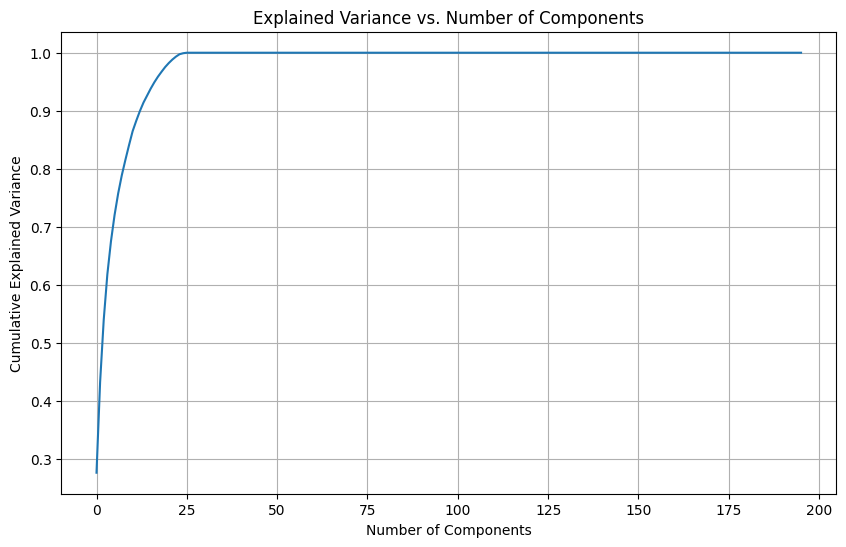

In [159]:
# Assuming you have your feature array named 'X' with shape (386, 196) and target array named 'y'
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sm_arr, yields, test_size=0.2, random_state=42)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(sm_arr)

# Visualize cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [172]:
def train_and_evaluate_rf(features, yields, test_size=0.2, components=25):
    # Perform PCA
    pca = PCA(n_components=components)
    reduced_data = pca.fit_transform(features)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(reduced_data, yields, test_size=test_size, random_state=24)

    # Initialize Random Forest regressor
    xgb_regressor = XGBRegressor()

    # Train the model
    xgb_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_regressor.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'Actual vs. Predicted Values for {components} components')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return trained model
    return xgb_regressor

In [162]:
!pip install joblib

In [168]:
import joblib

def save_trained_model(trained_model, model_filename, model_directory):
    try:
        # Construct the full path to the model file
        model_file_path = f"{model_directory}/{model_filename}"

        # Save the trained model
        joblib.dump(trained_model, model_file_path)
        print(f"Model saved successfully at: {model_file_path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

Mean Squared Error: 665.850467270705


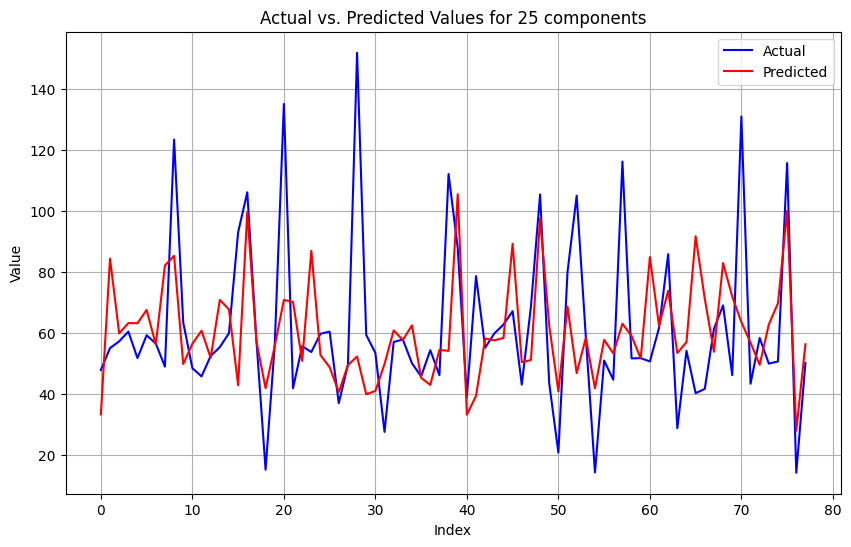

In [173]:
trained_model_xgb = train_and_evaluate_rf(sm_arr, yields)

Mean Squared Error: 651.2906225512819


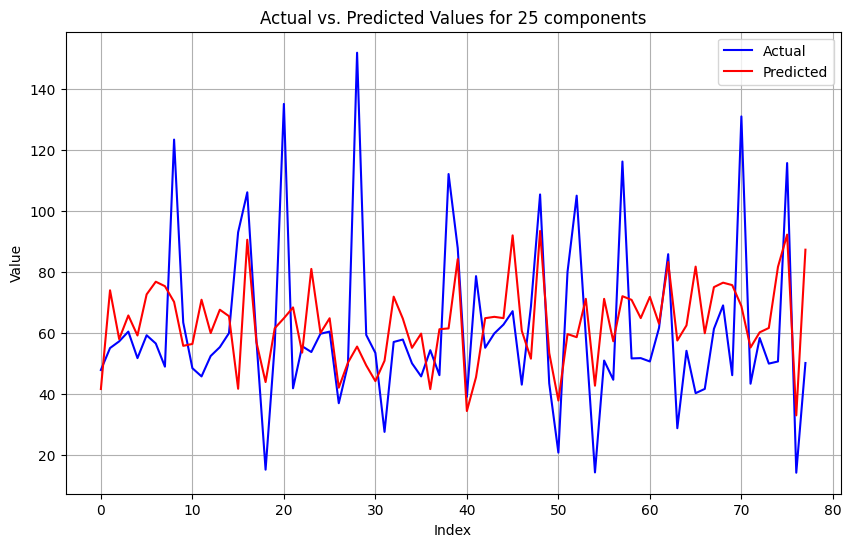

In [171]:
trained_model = train_and_evaluate_rf(sm_arr, yields)

In [174]:
model_filename = 'sm_model_xgb.pkl'
model_directory = '/content/drive/MyDrive/Conservatives-Official/Soil_Moisture/Soil_Moisture_new/'
save_trained_model(trained_model_xgb, model_filename, model_directory)

Model saved successfully at: /content/drive/MyDrive/Soil_Moisture_Data/sm_model_xgb.pkl
